# Train an image object detection model using Vertex AI AutoML (using APIs)

### Summary

This notebbok covers Vertex AI custom object detection model training using image dataset. This includes training, endpoint creation, model deployment to an endpoint and serving model endpoint for batch and online inference. 

### Prerequisites

 - Images dataset with objects to identify
 	- Dataset used in this notebook can be found [here](https://public.roboflow.com/object-detection/packages-dataset/5)

### Objectives

 - Setup resources
 - Image `Dataset` resource creation 
 - Import images in the dataset and create labels
 - Train custom AutoML `Model` resource for object tdetection
 - Evaluate the trained model
 - Create an `Endpoint` resource and deploy model 
 - Perform online & batch predictions on new data
 - [Optional] Creating new dataset using existing annotatons from Vertex AI managed dataset
 - Cleanup

#### Setup resources

In [1]:
# Load required packages to run the notebook

import json
import re
import requests
import base64
from typing import List, Union
from IPython.display import Image

from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import trainingjob, predict

In [2]:
# Setup variables for notebooks

LOCATION = "us-central1" 
PROJECT_ID = "nishitp-daml"
DATASET_ID = "4715062101670887424"
EXPORT_DIRECTORY = "gs://ds-ml-demos/packages-image-metadata/"
ANNOTATION_SET_ID = "package-classification_iod"
FILTER = f"labels.aiplatform.googleapis.com/annotation_set_name={ANNOTATION_SET_ID}"

In [3]:
# Creating helper functions for API calls

def manage_package_dataset_metadata(method, endpoint, data, auth_token):
    data = str(data)
    headers = {'Content-type': 'application/json', "Authorization": f"Bearer {auth_token}"}
    
    if method == "GET":
        resp = requests.get(endpoint, headers=headers)
    if method == "POST":
        resp = requests.post(endpoint, data=data, headers=headers)
    if method == "DELETE":
        resp = requests.delete(endpoint, headers=headers)
    
    return(resp.json())

#### Image `Dataset` resource creation

Let's create image dataset in the Vertex AI and import all images into our dataset. From the GCP console left task list pane, find and click on `Vertex AI` and then click on `Dataset` option to create a new dataset

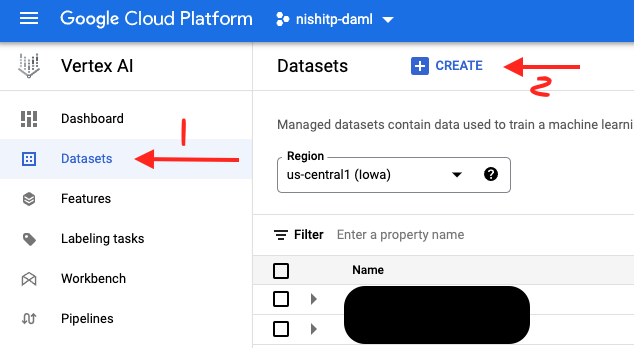

Once you are in the dataset `Create dataset` page, provide a name for dataset. We name our dataset `package-detection-ds` for this demo. Next, select `IMAGE` as dataset type and click on `Image object detection` option. Let's keep region and other setting as default for now. Next, click on `CREATE` button to create a new dataset resoure in Vertex AI.

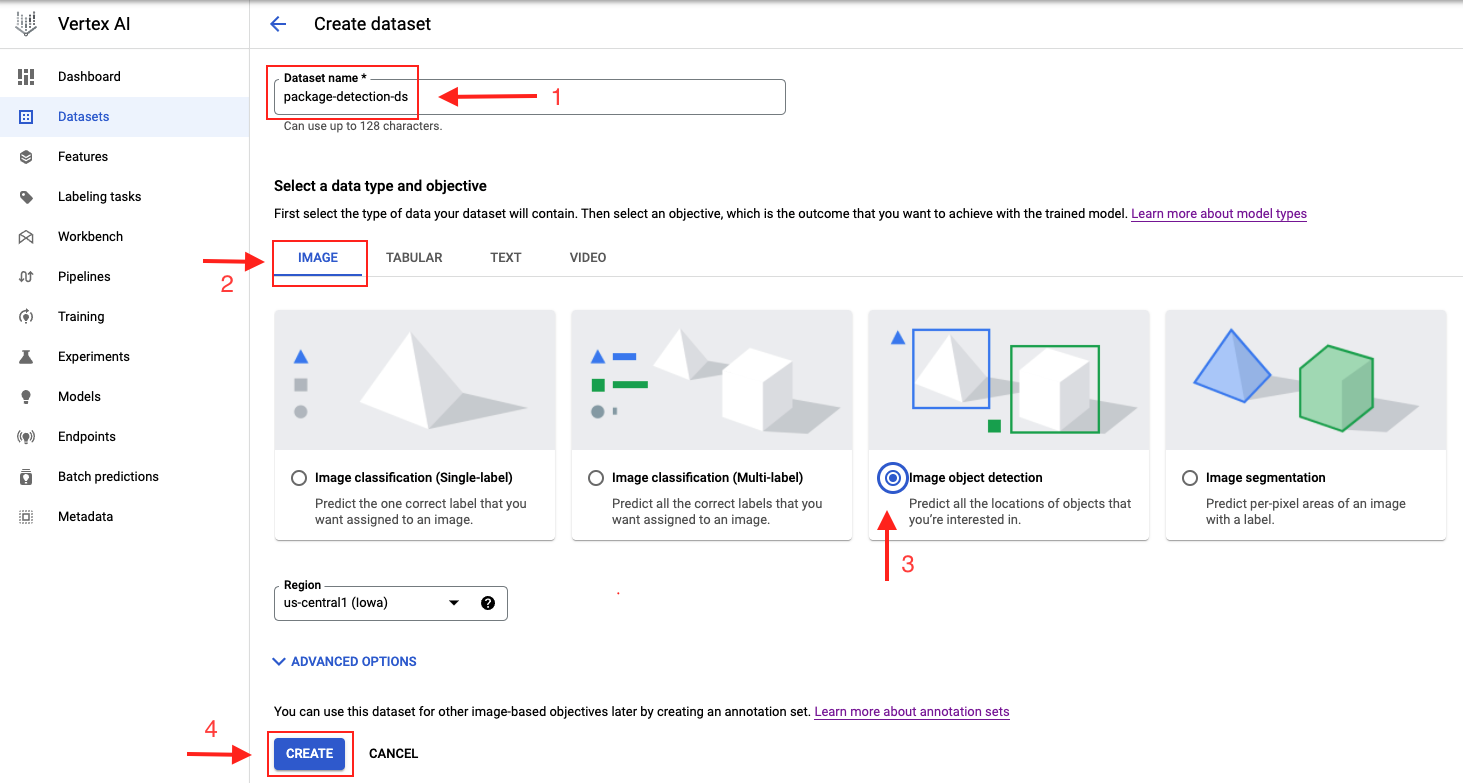

#### Import images in the dataset and create labels

When the dataset is created, you will click on the dataset and import the images for labeling and training the model. You have following options to import images from within Verte AI dataset:

- Upload from your local machine (limit 500 per upload)
- Upload import file from your local machine (this file will contains the path to images and other attributes)
- Select & import images from Cloud storage bucket (provide gcs location of the file. either jsonl or csv format)

For this demo, we will use the file that we already have in the cloud stoage bucket and import. To do this, click on `IMPORT` pane and select `Select import files form Cloud Storage` option and provide path to the file and click on `BROWSE` button to select the gcs storage bucket and file. Lastly, click on `CONTINUE` button to import the images. 

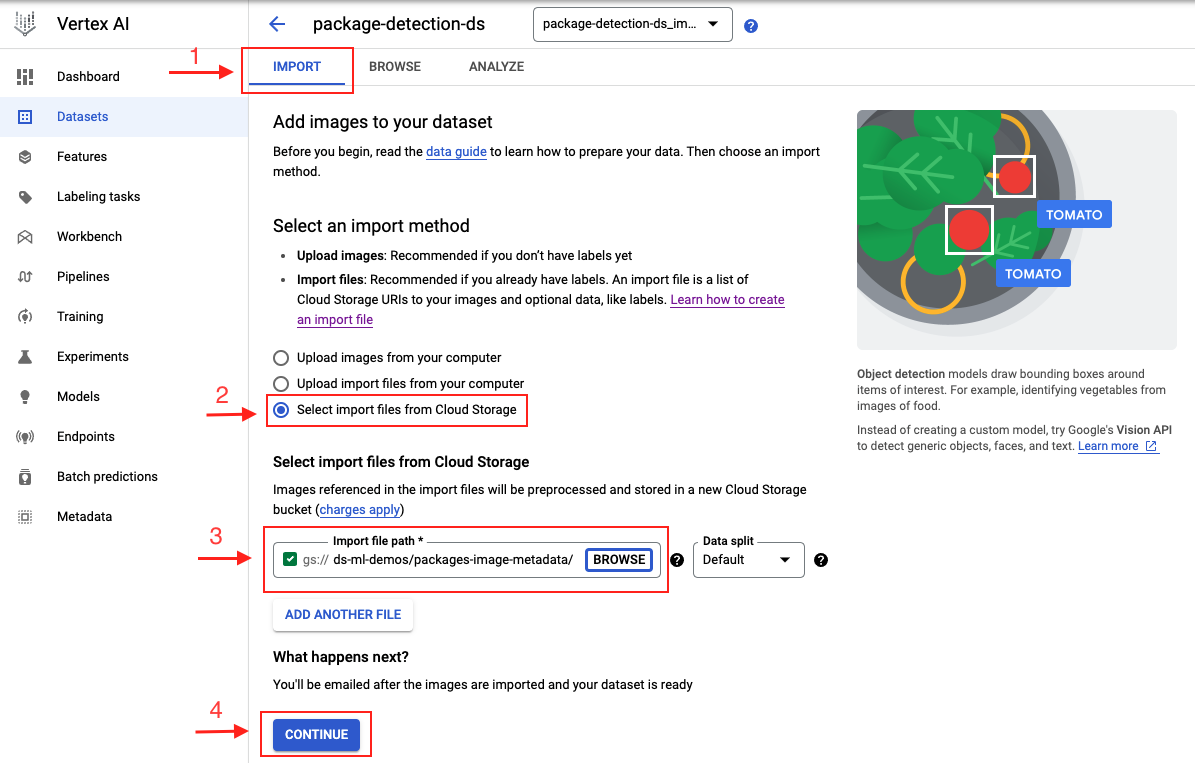

Once, all the images have been imported (based on dataset size it could take a while to load everything), you can browse it from the `BROWSE` pane of the dataset. You'll be able to create new labels for images and create boundaries around the object that you are trying to detect in the images. For example in this demo, we are trying to identify what kind of packages was delivered at the door. The labels are as follows:

- small_packages
- medium_packages
- big_packages
- envelopes

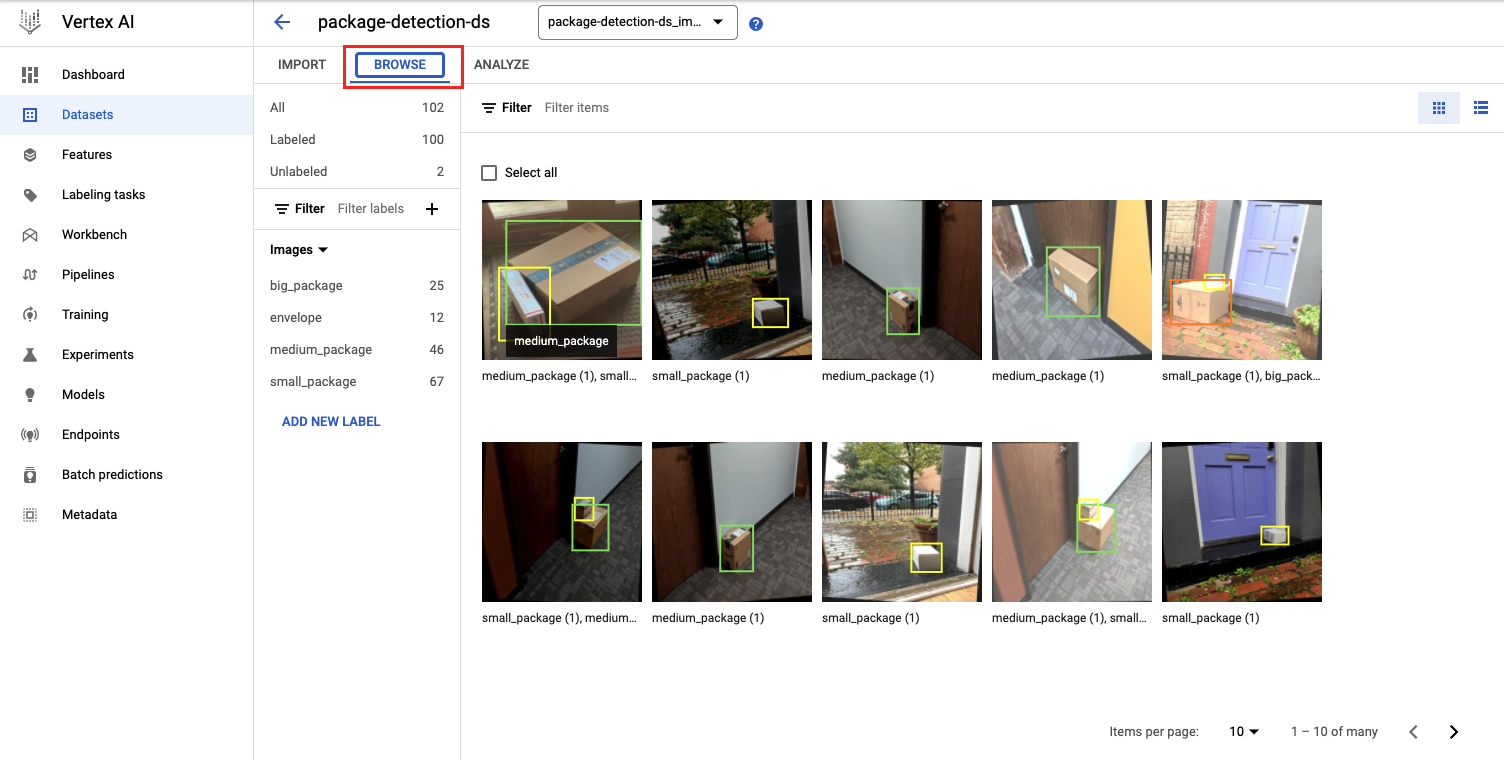

#### Train custom AutoML `Model` resource

After labeling all the images in our dataset, we are now ready to train the model. To do this, we will be using Vertex AI APIs. First, will create a function that will take custom inputs and starts the `Vertex AI training` resource.

Below are the function input description:

- `project`: your gcp project id
- `display_name`: vertex ai training resournce name in the console
- `dataset_id`: dataset id from previous step (check console->vertex ai->datasets->ID)
- `model_display_name`: trained model name shown in console
- `location`: location of your image dataset
- `api_endpoint`: gcp vertex ai api endpoint

In [4]:
# Training automl model

def train_package_size_detection(
    project: str,
    display_name: str,
    dataset_id: str,
    model_display_name: str,
    location: str,
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    
    # Initialize client that will be used to create and send requests. This only needs to be created once. 
    aip_client = aiplatform.gapic.PipelineServiceClient(client_options=client_options)
    
    training_inputs = trainingjob.definition.AutoMlImageObjectDetectionInputs(
        model_type="CLOUD_HIGH_ACCURACY_1", # goal is to train a model with high accuracy as opposed to low latency serving here
        budget_milli_node_hours=20000,      # this is the minimum numbee of node hours requires to train object detection model
        disable_early_stopping=False,
    ).to_value()

    training_pipeline = {
        "display_name": display_name,
        "training_task_definition": "gs://google-cloud-aiplatform/schema/trainingjob/definition/automl_image_object_detection_1.0.0.yaml",
        "training_task_inputs": training_inputs,
        "input_data_config": {"dataset_id": dataset_id},
        "model_to_upload": {"display_name": model_display_name},
    }
    parent = f"projects/{project}/locations/{location}"
    response = aip_client.create_training_pipeline(
        parent=parent, training_pipeline=training_pipeline
    )
    print("response:", response)


Let's train the model now:

In [6]:
# Start the training pipeline 
train_package_size_detection(PROJECT_ID,  
                             "package_size_detection_model_v1", 
                             DATASET_ID,
                             "package_size_detection_model_v1",
                             LOCATION
                            )

response: name: "projects/474014863033/locations/us-central1/trainingPipelines/554086790189809664"
display_name: "package_size_detection_model_v1"
input_data_config {
  dataset_id: "4715062101670887424"
}
training_task_definition: "gs://google-cloud-aiplatform/schema/trainingjob/definition/automl_image_object_detection_1.0.0.yaml"
training_task_inputs {
  struct_value {
    fields {
      key: "budgetMilliNodeHours"
      value {
        string_value: "20000"
      }
    }
    fields {
      key: "modelType"
      value {
        string_value: "CLOUD_HIGH_ACCURACY_1"
      }
    }
  }
}
model_to_upload {
  display_name: "package_size_detection_model_v1"
}
state: PIPELINE_STATE_PENDING
create_time {
  seconds: 1643244004
  nanos: 584731000
}
update_time {
  seconds: 1643244004
  nanos: 584731000
}



Once the model has been trained, you see that model resource in the Vertex AI `Training` page. In screenshot below, you can see that after running code from above cell, we have a new model named `paclage_size_detection_model_v1` created.

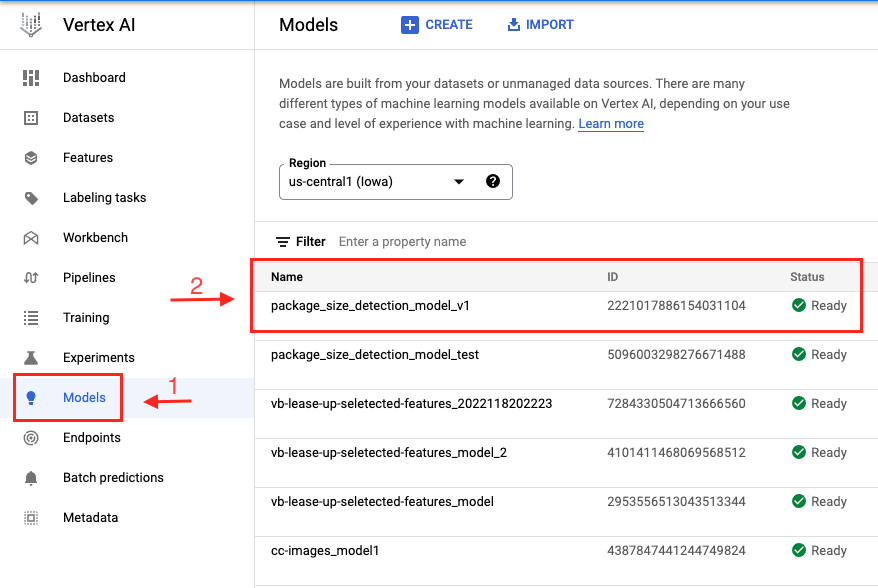

#### Evaluate the trained model

Now we will evaulate this trained model. 

In [7]:
# Get evaluation id
import re
model_client = aiplatform.gapic.ModelServiceClient(
        client_options={
            'api_endpoint':'us-central1-aiplatform.googleapis.com'
            }
        )

evaluations = model_client.list_model_evaluations(parent=f'projects/{PROJECT_ID}/locations/{LOCATION}/models/2221017886154031104')  #replace this model id with your model id
for val in evaluations:
    eval_group = re.search('evaluations/(.*)', val.name)
    model_group = re.search('models/(.*)/evaluations', val.name)
    
eval_id = eval_group.group(1)
model_id = model_group.group(1)


print(eval_id)
print(model_id)

5589020189002825728
2221017886154031104


In [8]:
# Funtion to get aggregated evaluation metrices

def evaluate_package_size_detection(
    project: str,
    model_id: str,
    evaluation_id: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
   
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    
    client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
    name = client.model_evaluation_path(
        project=project, location=location, model=model_id, evaluation=evaluation_id
    )
    response = client.get_model_evaluation(name=name)
    print("response:", response)


In [9]:
# Evaluate model
evaluate_package_size_detection(PROJECT_ID,  
                             model_id, 
                             eval_id
                            )

response: name: "projects/474014863033/locations/us-central1/models/2221017886154031104/evaluations/5589020189002825728"
metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/image_object_detection_metrics_1.0.0.yaml"
metrics {
  struct_value {
    fields {
      key: "boundingBoxMeanAveragePrecision"
      value {
        number_value: 0.80845743
      }
    }
    fields {
      key: "boundingBoxMetrics"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "confidenceMetrics"
                value {
                  list_value {
                    values {
                      struct_value {
                        fields {
                          key: "confidenceThreshold"
                          value {
                            number_value: 7.034036e-06
                          }
                        }
                        fields {
                          key: "f1Score"
   

#### Create an `Endpoint` resource and deploy model 

Let's create an endpoint to deploy model to.

In [10]:
def create_endpoint(
    project: str, display_name: str, location: str,
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint.create(
        display_name=display_name, project=project, location=location,
    )

    print(endpoint.display_name)
    print(endpoint.resource_name)
    return endpoint


In [11]:
end_point = create_endpoint(PROJECT_ID, "package-object-detection-endpoint", LOCATION)
end_point

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/474014863033/locations/us-central1/endpoints/7482669208224923648/operations/8633664986935197696
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/474014863033/locations/us-central1/endpoints/7482669208224923648
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/474014863033/locations/us-central1/endpoints/7482669208224923648')
package-object-detection-endpoint
projects/474014863033/locations/us-central1/endpoints/7482669208224923648


resource name: projects/474014863033/locations/us-central1/endpoints/7482669208224923648

Now we will evaulate the trained model. After running code from above cell, you will see a new endpoint created in Vertex AI `Endpoint` page like below. You can also see that the `Models` for this endpoint are 0 which indicates that there is no model deployed to this endpoint. So in next step we will deploy the model to this endpoint so we can make prediction request to this endpoint. Deploying model to an endpoint takes few minutes. 

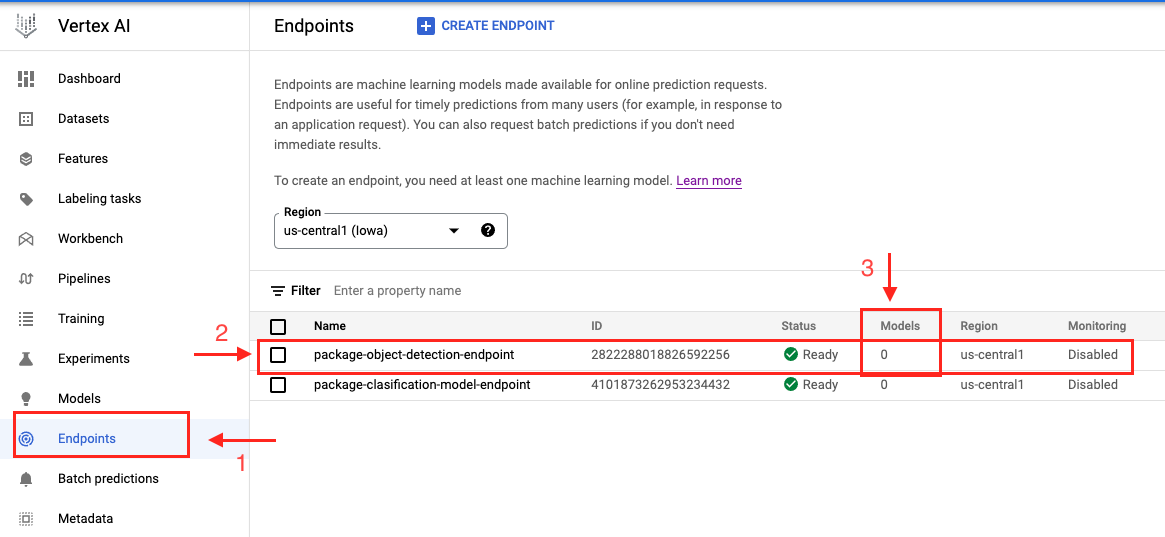

In [13]:
# deploying the model to endpoint

def deploy_package_detection_model(
    project: str,
    location: str,
    model_name: str,  # fully qualified name: projects/project_number/locations/location_name/models/model_number
    endpoint: str,
    deployed_model_display_name:  str,
    traffic_percentage:  int,
    traffic_split: dict,
    min_replica_count: int,
    max_replica_count: int,
    metadata: dict,
    sync: bool,
):

    aiplatform.init(project=project, location=location)
    model = aiplatform.Model(model_name=model_name)

    model.deploy(
        endpoint=endpoint,
        deployed_model_display_name=deployed_model_display_name,
        traffic_percentage=traffic_percentage,
        traffic_split=traffic_split,
        min_replica_count=min_replica_count,
        max_replica_count=max_replica_count,
        metadata=metadata,
        sync=sync,
    )

    model.wait()

    print(model.display_name)
    print(model.resource_name)
    return model

In [14]:
model_path = model.resource_name
deploy_package_detection_model(PROJECT_ID, LOCATION, model_path, end_point, "package_detection_model_v1", 0, None, 1, 1, (), True)

INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/474014863033/locations/us-central1/endpoints/7482669208224923648
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/474014863033/locations/us-central1/endpoints/7482669208224923648/operations/822171433261072384
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/474014863033/locations/us-central1/endpoints/7482669208224923648
package_size_detection_model_v1
projects/474014863033/locations/us-central1/models/2221017886154031104


resource name: projects/474014863033/locations/us-central1/models/2221017886154031104

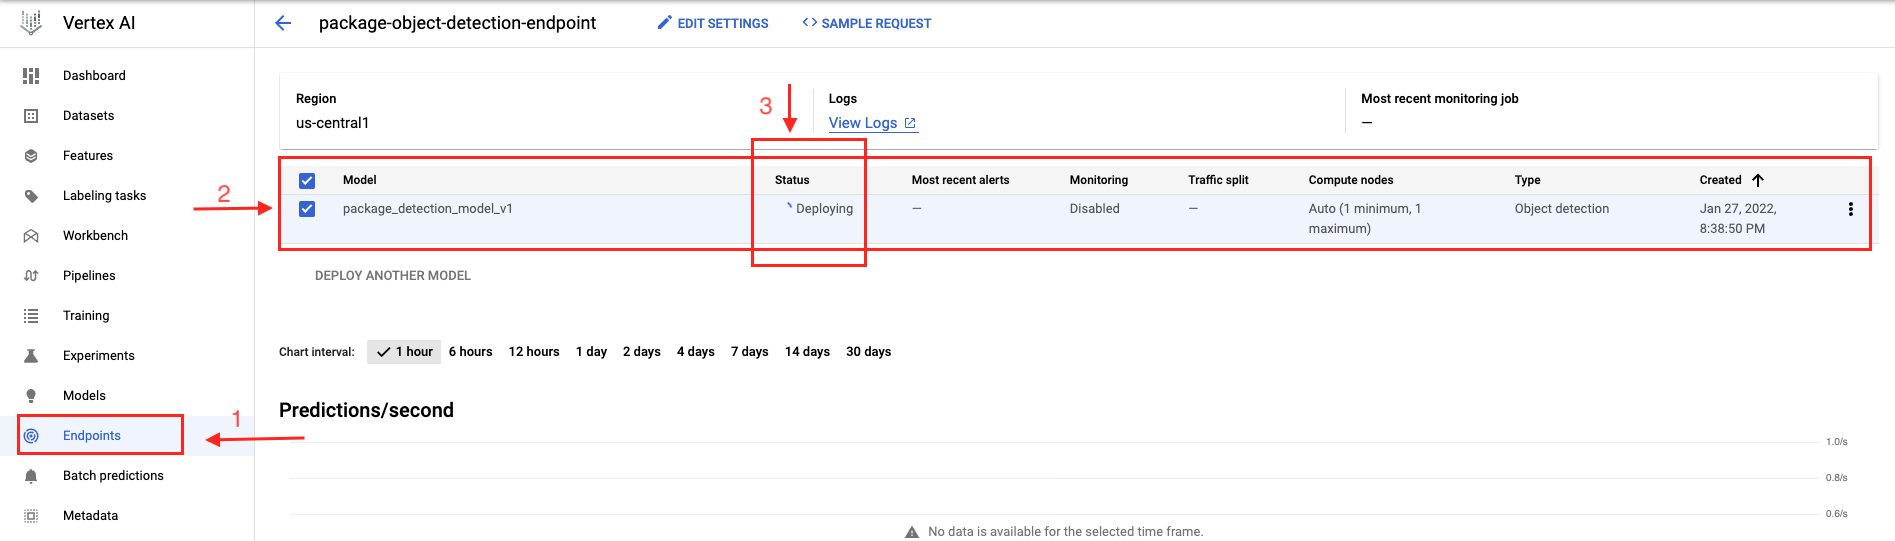

Once the model has been deployed successfully, you will see `Status` as ready like below

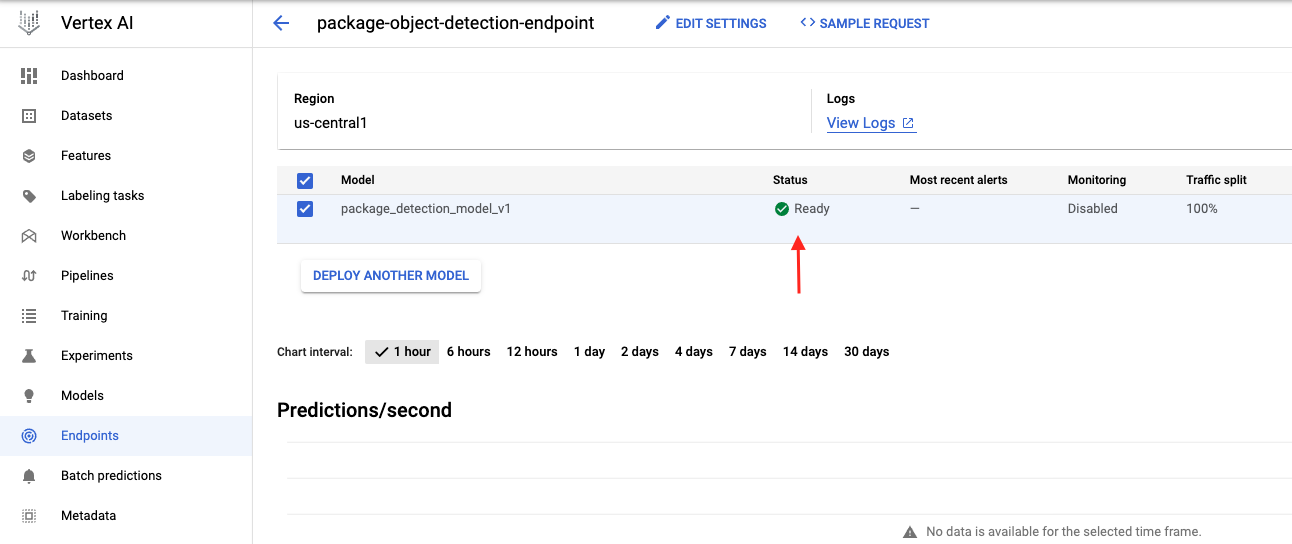

We are now ready to make prediction request to this endpoint using model deployed. Let's create another methoed to do this

#### Online & batch predictions

##### Online prediction

In [15]:
# prediction request

def get_package_detection_predictions(
    project: str,
    endpoint_id: str,
    filename: str,
    location: str,
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    
    with open(filename, "rb") as f:
        file_content = f.read()

    # The format of each instance should conform to the deployed model's prediction input schema.
    encoded_content = base64.b64encode(file_content).decode("utf-8")
    instance = predict.instance.ImageObjectDetectionPredictionInstance(
        content=encoded_content,
    ).to_value()
    instances = [instance]
    
    # See gs://google-cloud-aiplatform/schema/predict/params/image_object_detection_1.0.0.yaml for the format of the parameters.
    parameters = predict.params.ImageObjectDetectionPredictionParams(
        confidence_threshold=0.5, max_predictions=5,
    ).to_value()
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    
    predictions = response.predictions
    for prediction in predictions:
        print(" prediction:", dict(prediction))

In [21]:
filename = "package-images_IMG_6817_jpg.rf.2b27ee700087707e9721d9ef99180953.jpg"
end_pt_str = end_point.resource_name
end_point_id = end_pt_str[end_pt_str.rindex('/')+1:]
get_package_detection_predictions(PROJECT_ID, end_point_id, filename, LOCATION)

 prediction: {'confidences': [0.977389872], 'ids': ['8059155249295785984'], 'bboxes': [[0.532388628, 0.637344182, 0.714642763, 0.819512486]], 'displayNames': ['small_package']}


##### Batch prediction

Batch predictions are async type requests which can directly be requested to model resource in `Vertex AI`. You don't need to deploy the model to an endpoint to perform batch predictions. To do this, you will need to specify an input resource and an location where output or model results can be written and stored. 

For batch prediction, AutoML image model requires an input resource in the form of [JSON lines](https://jsonlines.org/) and Google cloud storage bucket to store the output

In [25]:
GCS_IN_PATH = "gs://ds-ml-demos/package-image-batch-predictions/input/batch-prediction-inputs.jsonl"
GCS_OUT_PATH = "gs://ds-ml-demos/package-image-batch-predictions/output/"

In [26]:
#function for batch prediction

def get_package_detection_batch_predictions(
    project: str,
    location: str,
    model_resource_name: str,
    job_display_name: str,
    gcs_source,
    gcs_destination: str,
    sync: bool = True,
):
    aiplatform.init(project=project, location=location)

    model = aiplatform.Model(model_resource_name)

    batch_prediction_job = model.batch_predict(
        job_display_name=job_display_name,
        gcs_source=gcs_source,
        gcs_destination_prefix=gcs_destination,
        sync=sync,
    )

    batch_prediction_job.wait()

    print(batch_prediction_job.display_name)
    print(batch_prediction_job.resource_name)
    print(batch_prediction_job.state)
    return batch_prediction_job


In [27]:
get_package_detection_batch_predictions(PROJECT_ID, 
                                        LOCATION,
                                        model_path,
                                        "package_detection_batch_prediction_job",
                                        GCS_IN_PATH,
                                        GCS_OUT_PATH
                                       )

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/474014863033/locations/us-central1/batchPredictionJobs/3383341314689990656
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/474014863033/locations/us-central1/batchPredictionJobs/3383341314689990656')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/3383341314689990656?project=474014863033
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/474014863033/locations/us-central1/batchPredictionJobs/3383341314689990656 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/474014863033/locations/us-central1/batchPredictionJobs/3383341314689990656 current state:
JobState.JOB_STAT

resource name: projects/474014863033/locations/us-central1/batchPredictionJobs/3383341314689990656

Once you submit the batch prediction job to the `Vertex AI`, you will see it in console and depending on how many instances you have in your prediction request it can take a while to completely finish this batch prediction job. You can see in below screenshot how batch prediction job looks in `Vertex AI` console. 

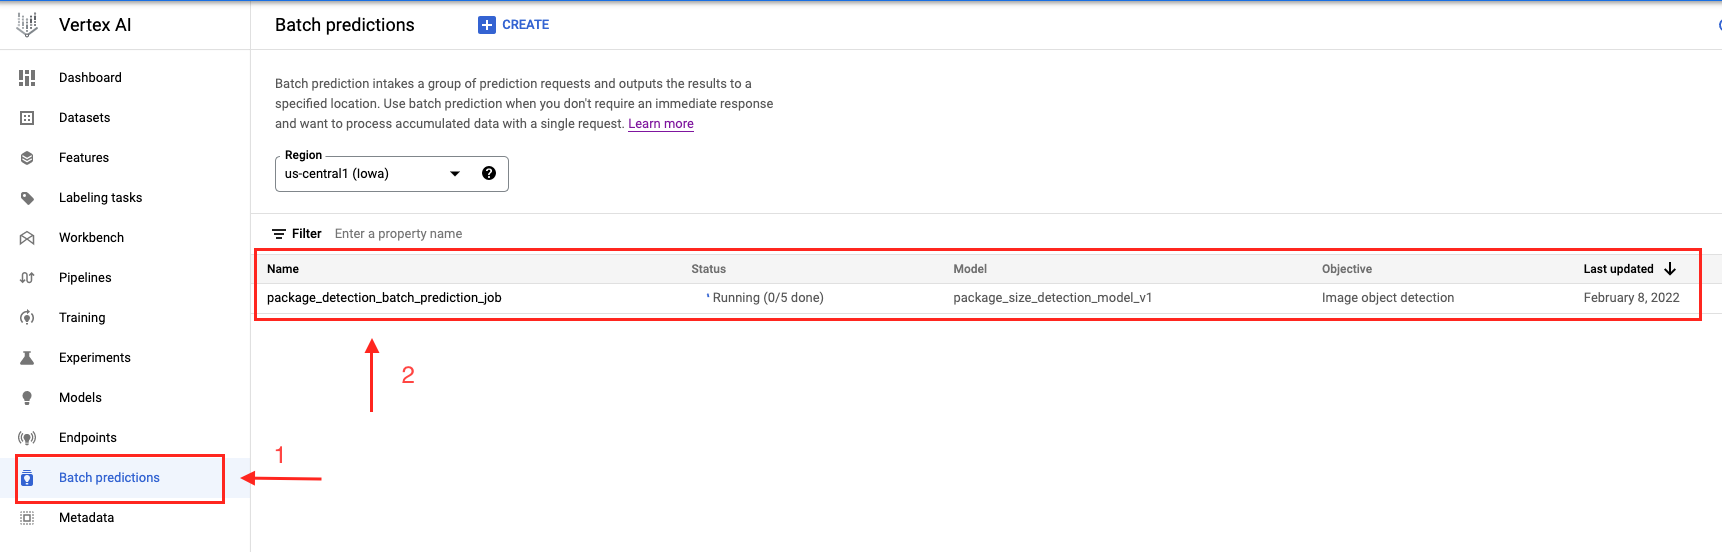

Once the job is finished, you can see `Status` as complete like below

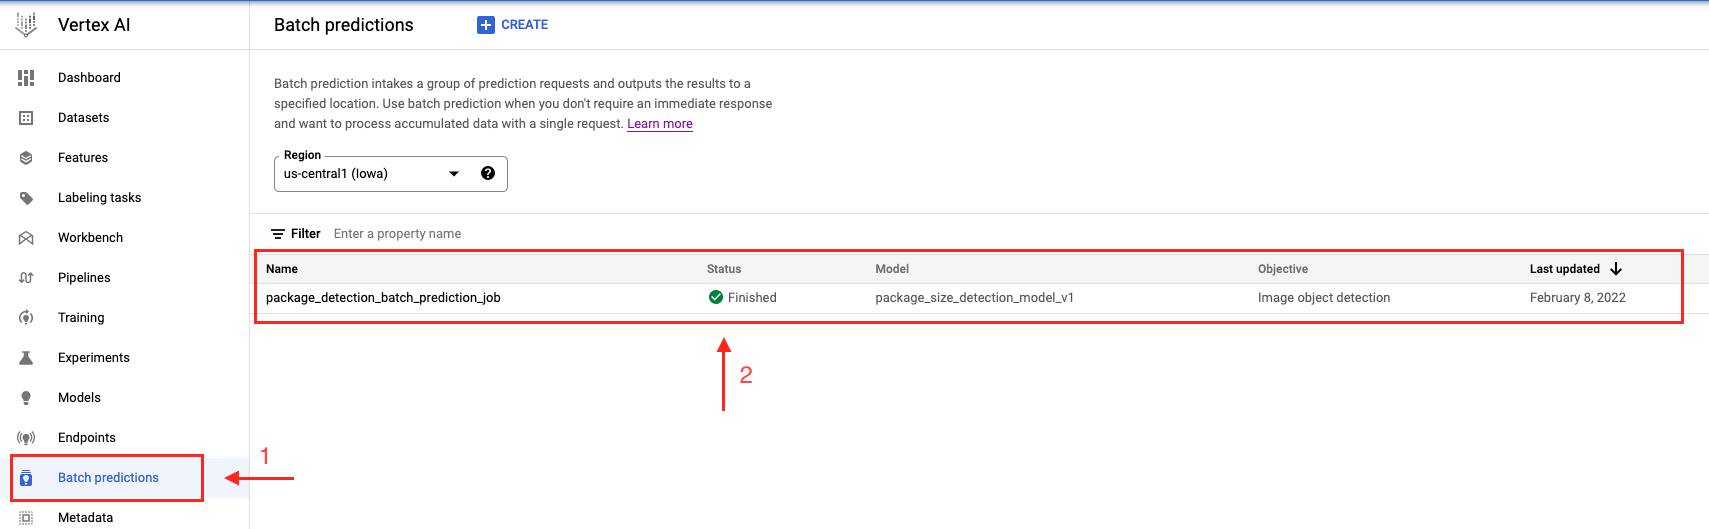

You can navigate to your cloud storage batch prediction output bucket to see the prediction file that was created as a result of this job

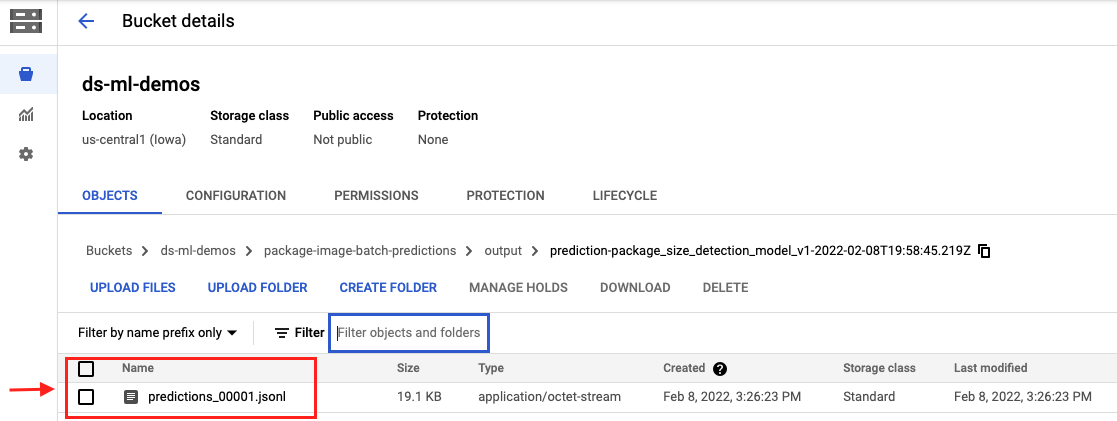

#### [Optional] Creating new dataset using existing annotsations from Vertex AI managed `Dataset` resource

Once you have labeled images dataset, you can export the annotations and make changes in case you want to reuse dataset for different purpose or change the labels itself in the dataset. This is a great option that saves ton of time that is spent doing manually otherwise. Basically by exporting the annotations of an existing dataset, you can make necessary changes both in label and other metadata of images to train other models. 

For example, the dataset we used in this notebook for object detection, can also be used as image classification where we would remove the bounding boxes and may modify the label class (In this case we don't need as packages stays the same)

To create a new dataset using existing annotations, you will need to copy the annotation set name and bucket where the annotated lable will be exported. We will create a json file named `annotate_payload.json` call api to create this new dataset in AutoML.

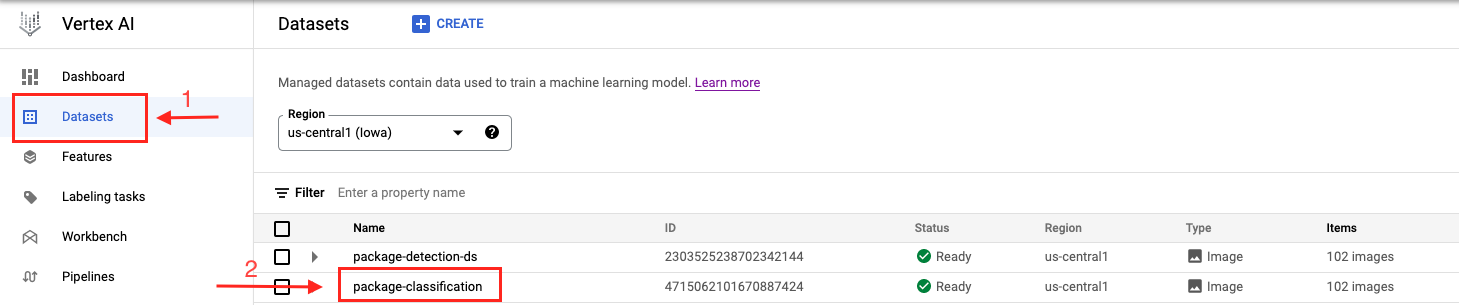

Click on the AutoML image detection dataset and then copy the annotation_set_name from top drop down menu

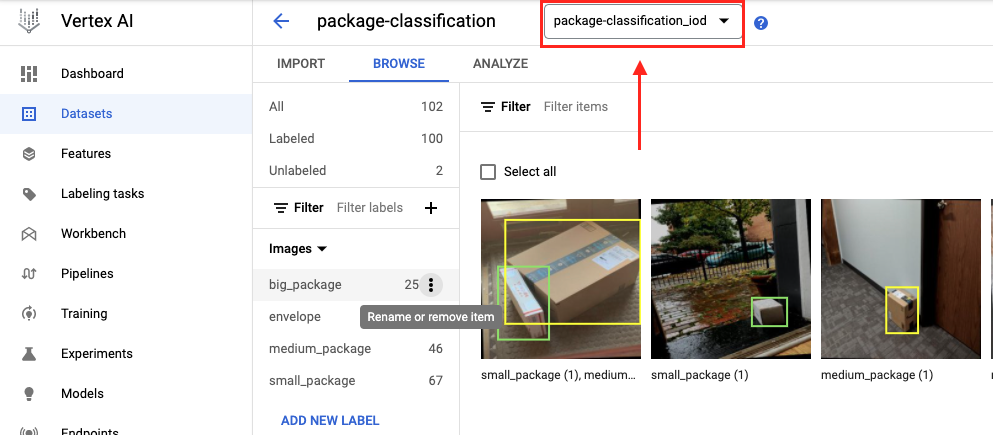

In [30]:
%%writefile files/annotate_payload.json

{
  "exportConfig": {
    "gcsDestination": {
      "outputUriPrefix": "gs://ds-ml-demos/packages-image-metadata/"
    },
    "annotationsFilter": "labels.aiplatform.googleapis.com/annotation_set_name=package-classification_iod"
  }
}


Writing files/annotate_payload.json


In [31]:
with open('files/annotate_payload.json', 'r') as myfile:
    data=myfile.read()
    
print(data)


{
  "exportConfig": {
    "gcsDestination": {
      "outputUriPrefix": "gs://ds-ml-demos/packages-image-metadata/"
    },
    "annotationsFilter": "labels.aiplatform.googleapis.com/annotation_set_name=package-classification_iod"
  }
}



We will now call the API to export these annotations and write to a file in cloud storage bucket 

In [33]:
# api endpoint for annotation extration
api_endpoint = f"https://{LOCATION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{LOCATION}/datasets/{DATASET_ID}:export"

In [34]:
#Create dataset

response = manage_package_dataset_metadata(method="POST", endpoint=api_endpoint, data=data, auth_token=token)
response

{'name': 'projects/474014863033/locations/us-central1/datasets/4715062101670887424/operations/1386695887333359616',
 'metadata': {'@type': 'type.googleapis.com/google.cloud.aiplatform.v1.ExportDataOperationMetadata',
  'genericMetadata': {'createTime': '2022-02-11T01:49:49.136753Z',
   'updateTime': '2022-02-11T01:49:49.136753Z'},
  'gcsOutputDirectory': 'gs://ds-ml-demos/packages-image-metadata/export-data-package-classification-2022-02-11T01:49:49.059650Z'}}

As you can see in above output, a new file has been created in cloud storage bucket. 

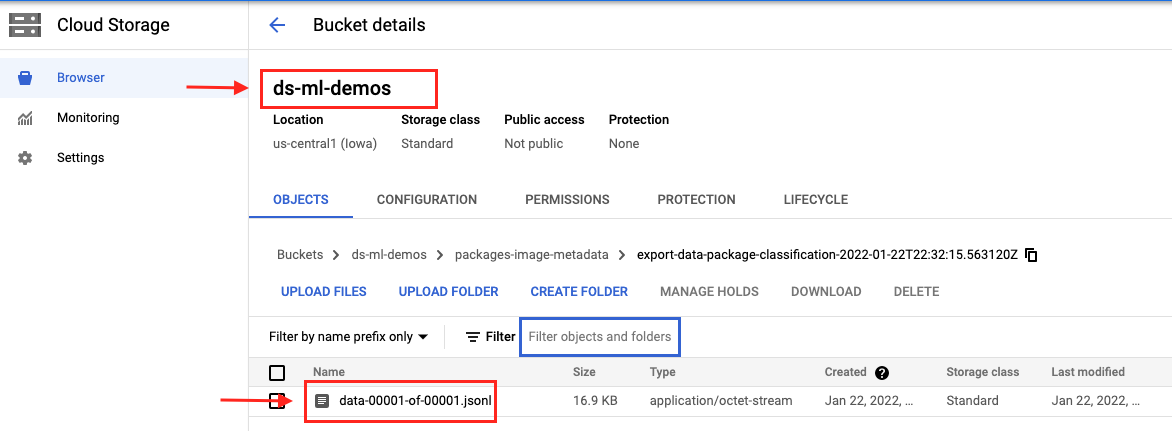

We will now import images in dataset created in previous step. To do this, copy the file path from cloud storage bucket. 

In [35]:
file_path = "gs://ds-ml-demos/packages-image-metadata/export-data-package-classification-2022-01-25T01:28:18.411854Z/image_bounding_box/package-classification_iod-1108241750100541440/data-00001-of-00001.jsonl"

We will now create a function that will take below parameter as input and create and import images into an AutoML dataset:
    
- `project`: dataset project name 
- `location`: location of vertex ai dataset
- `display_name`: display name of dataset in console
- `src_uri`: uri of annotation json file name

In [36]:
# Create Vertex AI dataset using api

def create_package_size_image_dataset(
    project: str,
    location: str,
    display_name: str,
    src_uris: str,
    sync: bool = True,
):

    aiplatform.init(project=project, location=location)

    ds = aiplatform.ImageDataset.create(
        display_name=display_name,
        gcs_source=src_uris,
        import_schema_uri="gs://google-cloud-aiplatform/schema/dataset/ioformat/image_bounding_box_io_format_1.0.0.yaml", # uri for image object detection schema standard
        sync=sync,
    )

    ds.wait()

    print(ds.display_name)
    print(ds.resource_name)
    return ds


In [38]:
# Call API to create dataset in Vertex AI
create_package_size_image_dataset(PROJECT_ID, LOCATION, "package-detection-dataset", file_path)

INFO:google.cloud.aiplatform.datasets.dataset:Creating ImageDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create ImageDataset backing LRO: projects/474014863033/locations/us-central1/datasets/6219369930328899584/operations/9087851250136907776
INFO:google.cloud.aiplatform.datasets.dataset:ImageDataset created. Resource name: projects/474014863033/locations/us-central1/datasets/6219369930328899584
INFO:google.cloud.aiplatform.datasets.dataset:To use this ImageDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.ImageDataset('projects/474014863033/locations/us-central1/datasets/6219369930328899584')
INFO:google.cloud.aiplatform.datasets.dataset:Importing ImageDataset data: projects/474014863033/locations/us-central1/datasets/6219369930328899584
INFO:google.cloud.aiplatform.datasets.dataset:Import ImageDataset data backing LRO: projects/474014863033/locations/us-central1/datasets/6219369930328899584/operations/2684577004946194432
INFO:google.clo

resource name: projects/474014863033/locations/us-central1/datasets/6219369930328899584

Once you run the above command, you can see a new dataset being prepared and images being imported. When all the images are finished importing, you will be able to see the
annotation already created and now you are all set for further analysis and modeling. 

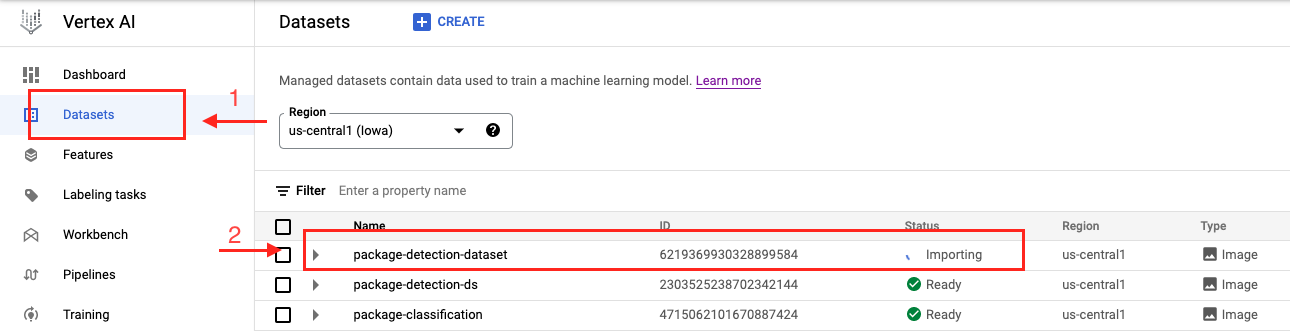

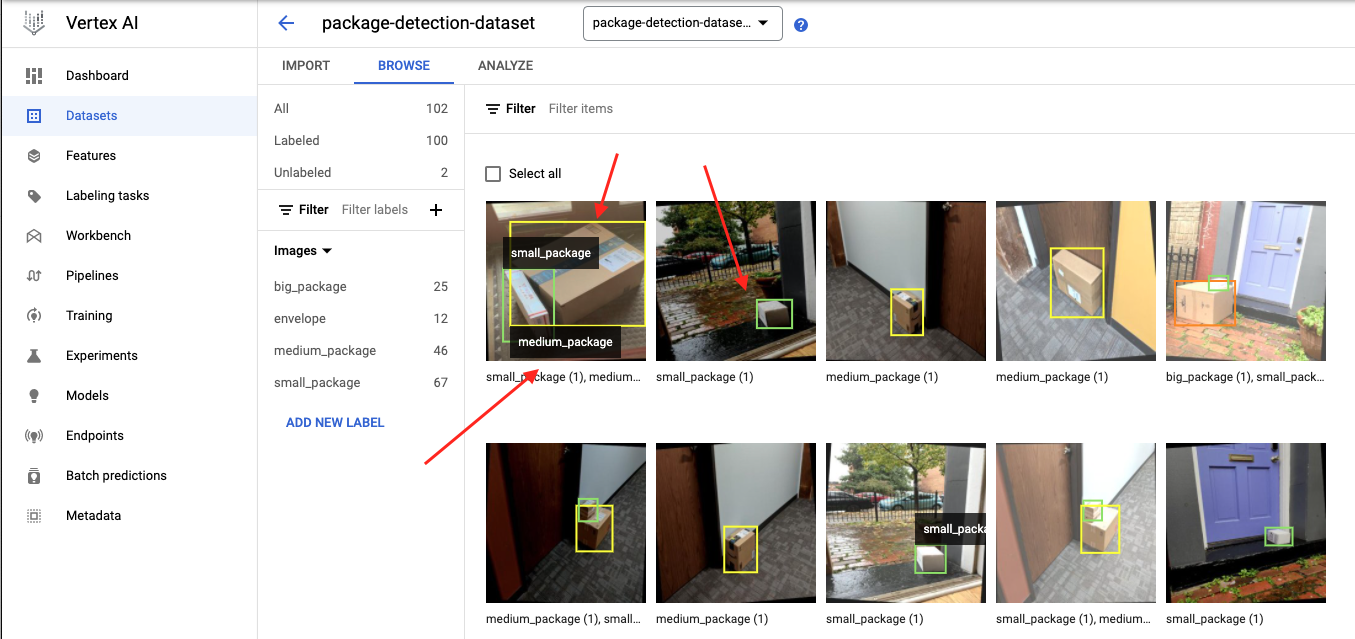